In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')


Using Colab cache for faster access to the 'creditcardfraud' dataset.
Data source import complete.


## DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data
Using a Gaussian Mixture Model (GMM) to generate synthetic samples for the minority class, and then evaluate its effectiveness compared to a baseline model.

### 1. Problem Statement

You are a data scientist tasked with building a fraud detection model for a financial institution. You have been given a highly imbalanced dataset where a tiny fraction of transactions are fraudulent. Your main challenge is to create a training set that allows a classifier to learn the nuances of the minority (fraudulent) class without overfitting or misclassifying. You will implement a GMM-based synthetic data generation pipeline and analyze its impact on model performance.

# **Part A: Data Exploration & Baseline Model**

In [ ]:
# 1. Load and Analyze the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

## 1. Loading Dataset

The credit card fraud detection dataset is a highly imbalanced dataset. The core challenge is to robustly identify fraudulent transactions (minority class) without being misled by the overwhelming number of legitimate transactions (majority class).

We will first begin with data exploration and then establish a logistic regression baseline, using key fraud detection metrics for evaluation.

In [ ]:
# Load dataset (Kaggle provides creditcard.csv once you add the dataset)
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

print("Dataset shape:", df.shape)
print("\nPreview of dataset:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum().sum(), "missing values total")


Dataset shape: (284807, 31)

Preview of dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Missing values per column:
0 missing values total


### Understanding the data:
The dataset contains transactions made by European cardholders. The features `V1` through `V28` are the result of a PCA transformation, and the `Time` and `Amount` columns are the only original features.

The most important column for our task is `Class`, which indicates whether a transaction is fraudulent (`1`) or not (`0`). Let's examine the distribution of this class.

Also there are no missing values.

## 2. Analyze Class Distribution

In [ ]:
# 2. Analyze Class Distribution
class_counts = df['Class'].value_counts().sort_index()
fraud_count = class_counts[1]
nonfraud_count = class_counts[0]
fraud_pct = fraud_count / len(df) * 100
imbalance_ratio = nonfraud_count / fraud_count

print("\nClass distribution:")
print(f"Non-Fraud (0): {nonfraud_count}")
print(f"Fraud (1): {fraud_count}")
print(f"Fraudulent transactions = {fraud_pct:.3f}% of total")
print(f"Imbalance Ratio (Non-Fraud : Fraud) = {imbalance_ratio:.2f} : 1")


Class distribution:
Non-Fraud (0): 284315
Fraud (1): 492
Fraudulent transactions = 0.173% of total
Imbalance Ratio (Non-Fraud : Fraud) = 577.88 : 1


**The dataset shows extreme class imbalance—fraudulent transactions are only a tiny fraction of all records. This necessitates specialized approaches, as standard classifiers would be biased towards predicting the majority class (non-fraud).**

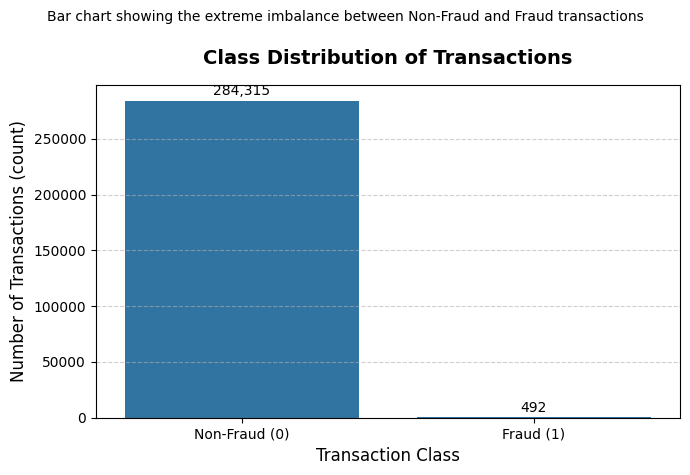

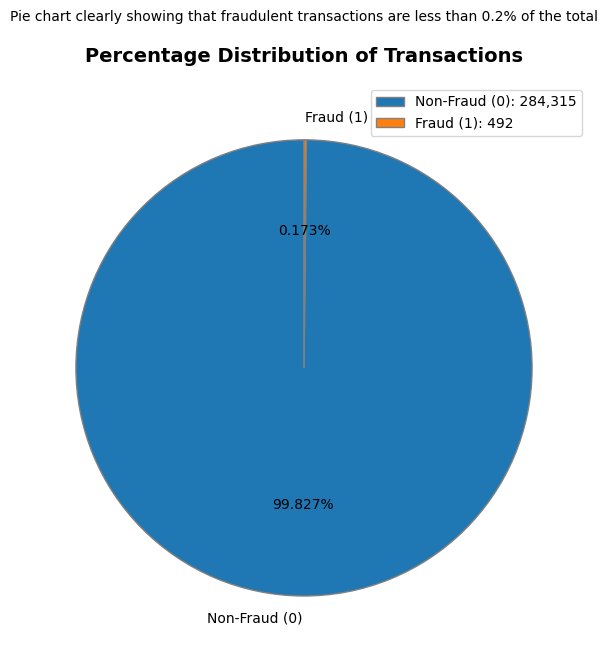

In [ ]:
# Plot class distribution for better visualization
plt.figure(figsize=(7,5))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.xlabel("Transaction Class", fontsize=12)
plt.ylabel("Number of Transactions (count)", fontsize=12)

# Titles
plt.title("Class Distribution of Transactions", fontsize=14, weight='bold', pad=15)
plt.suptitle(
    "Bar chart showing the extreme imbalance between Non-Fraud and Fraud transactions",
    fontsize=10, y=0.94
)

# Annotate bar values with counts
for i, val in enumerate(class_counts.values):
    plt.text(i, val + 2000, f"{val:,}", ha='center', va='bottom', fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Pie chart of class distribution
plt.figure(figsize=(7,7))
plt.pie(
    class_counts.values,
    labels=['Non-Fraud (0)', 'Fraud (1)'],
    autopct='%1.3f%%',
    startangle=90,  # Use default colors
    wedgeprops={'edgecolor': 'gray'}
)
plt.title("Percentage Distribution of Transactions", fontsize=14, weight='bold', pad=15)
plt.suptitle(
    "Pie chart clearly showing that fraudulent transactions are less than 0.2% of the total",
    fontsize=10, y=0.94
)
plt.legend(
    labels=[f"Non-Fraud (0): {class_counts[0]:,}", f"Fraud (1): {class_counts[1]:,}"],
    loc="upper right",
    fontsize=10
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Implementing a log-scaled y-axis, which makes both bars visible while preserving proportions, beacause of the highly imbalanced dataset.

*It is just for visulaization, we dont used log scaled axis in the notebook further.*

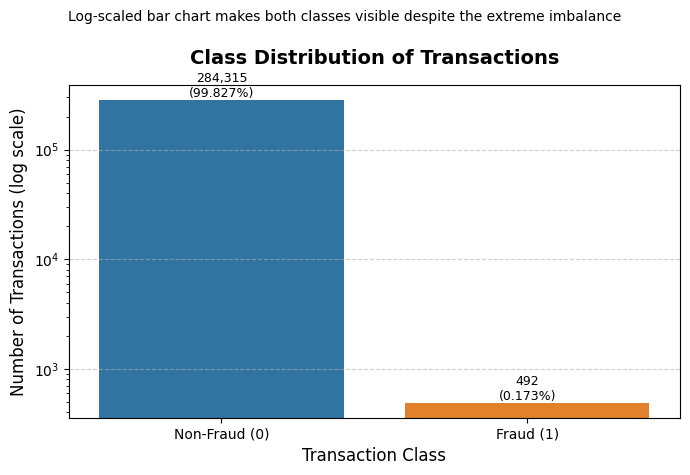

In [ ]:
# Create a temporary dataframe for Seaborn
import pandas as pd

df = pd.DataFrame({
    "Class": ['Non-Fraud (0)', 'Fraud (1)'],
    "Count": class_counts.values,
    "Hue": ['Non-Fraud', 'Fraud']  # temporary hue for colors
})

# Bar Plot with Log-Scaled Y-Axis
plt.figure(figsize=(7,5))
ax = sns.barplot(
    data=df,
    x="Class",
    y="Count",
    hue="Hue",
    dodge=False,
    palette=["#1f77b4", "#ff7f0e"]
)

plt.xlabel("Transaction Class", fontsize=12)
plt.yscale("log")
plt.ylabel("Number of Transactions (log scale)", fontsize=12)

# Titles
plt.title("Class Distribution of Transactions", fontsize=14, weight='bold', pad=15)
plt.suptitle(
    "Log-scaled bar chart makes both classes visible despite the extreme imbalance",
    fontsize=10, y=0.94
)

# Annotate values with counts + percentages
for i, val in enumerate(class_counts.values):
    pct = val / class_counts.sum() * 100
    plt.text(i, val, f"{val:,}\n({pct:.3f}%)",
             ha='center', va='bottom', fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.6)

# Remove legend if you don't need it
ax.legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


As the number of fraudulent transactions is a tiny fraction of the total. This confirms that we need to use special techniques to train our model effectively.

Next, we'll scale the `Amount` and `Time` features to ensure that all features have a similar scale. This is important for many machine learning algorithms, including the Logistic Regression model we'll be using.

## 3. Baseline Model

In [ ]:
# 3. Baseline Model
# Features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
# Split with stratify to preserve imbalance in test set
from sklearn.model_selection import train_test_split

# Split with stratify to preserve imbalance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("\nTrain/Test Split Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test: ", X_test.shape, "y_test: ", y_test.shape)

# Function to print counts and proportions
def print_distribution(name, y):
    counts = y.value_counts().sort_index()
    proportions = y.value_counts(normalize=True).sort_index() * 100
    print(f"\nClass distribution in {name}:")
    for cls in counts.index:
        print(f"Class {cls}: {counts[cls]} ({proportions[cls]:.3f}%)")

# Original dataset
print_distribution("original dataset", y)

# Training set
print_distribution("training set", y_train)

# Test set
print_distribution("test set", y_test)


Train/Test Split Shapes:
X_train: (199364, 30) y_train: (199364,)
X_test:  (85443, 30) y_test:  (85443,)

Class distribution in original dataset:
Class 0: 284315 (99.827%)
Class 1: 492 (0.173%)

Class distribution in training set:
Class 0: 199020 (99.827%)
Class 1: 344 (0.173%)

Class distribution in test set:
Class 0: 85295 (99.827%)
Class 1: 148 (0.173%)


In [ ]:
# Scale features (Logistic Regression benefits from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, let's build a baseline model using Logistic Regression on the original, imbalanced data. This will give us a starting point to compare the performance of our resampling techniques. We will use a standard train-test split to evaluate the model's performance on unseen data.

In [89]:
# Train Logistic Regression (baseline)
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight= "balanced")
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)


print("\n=== Baseline Logistic Regression (Imbalanced Data) ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


=== Baseline Logistic Regression (Imbalanced Data) ===
Accuracy:  0.979
Precision: 0.067
Recall:    0.878
F1-score:  0.124
ROC AUC:   0.968

Confusion Matrix:
[[83484  1811]
 [   18   130]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.979     0.989     85295
           1      0.067     0.878     0.124       148

    accuracy                          0.979     85443
   macro avg      0.533     0.929     0.557     85443
weighted avg      0.998     0.979     0.988     85443



The baseline model achieves high accuracy, but this is a misleading metric in the context of imbalanced data. A model that always predicts "not fraud" would still have high accuracy as Fraud cases are only ~0.17% of all transactions.

The **precision** and **recall** scores are the problem.
A trivial model predicting all transactions as 'Non-Fraud' would achieve >99% accuracy but recall = 0 (misses all frauds), meaning the model is failing to identify a large number of fraudulent transactions. This is not acceptable for a fraud detection system. The confusion matrix also shows a high number of false negatives.


Therefore, precision, recall, and F1-score (for minority class) are better indicators of performance in fraud detection.


**Terms:**

accuracy= how many correct predictions

pecision= Of all transactions flagged as fraud, how many were actually fraud.

recall(sensitivity)=Of all actual frauds, how many did the model catch.

F1 score=Balances how many frauds we detect and how accurate those detections are. Useful when classes are imbalanced.

ROC-AUC=Measures the model’s ability to distinguish between classes across all thresholds. If you randomly pick a fraud transaction and a non-fraud transaction, there’s a 95.4% chance the model assigns a higher fraud probability to the fraud transaction.

# **Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling**

### 1.  Theoretical foundation: GMM-based synthetic sampling vs SMOTE

**SMOTE**  
SMOTE (Synthetic Minority Over-sampling Technique) creates new minority samples by *linear interpolation* between existing minority instances and their nearest minority neighbours:

$$
x_{\text{new}} = x_i + \lambda (x_{nn} - x_i), \quad \lambda \sim \text{Uniform}(0,1)
$$

It is simple, local, and deterministic up to the random $(\lambda)$. It does not attempt to learn a global probability model of the minority class; instead it fills-in between observed points.

**GMM-based sampler**  
A Gaussian Mixture Model fits the minority-class distribution as a weighted sum of Gaussian components:
$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

where $(\pi_k)$ are mixing weights, $(\mu_k)$ component means and $(\Sigma_k)$ covariances. After fitting (e.g. with EM), synthetic samples are drawn from the learned mixture — i.e. sample a component $(k)$ with probability $(\pi_k)$, then draw

$$
x \sim \mathcal{N}(\mu_k, \Sigma_k)
$$

---

## Key differences and why GMM can be better

A Gaussian Mixture Model (GMM) models the probability distribution of the minority class as a mixture of multiple Gaussian distributions (“clusters”). Unlike simpler methods like SMOTE, GMM-based sampling:
* Can capture multi-modal structures (multiple clusters) in the data
* Generates synthetic samples that more accurately reflect the real distribution of fraud cases,
* Is especially valuable when the minority class is not well represented by a single cluster or is complex in shape.


---

### Why Use GMM for Minority Class Oversampling?

Unlike basic oversampling techniques (such as SMOTE, which interpolates linearly between nearest neighbors), a Gaussian Mixture Model (GMM) explicitly models the underlying probability distribution of the minority class as a combination of multiple Gaussian "clusters."

Key advantages:
1. **Captures Multi-Modal Structure:** If the minority class actually consists of several distinct sub-types (e.g., different types of fraud), each with its own cluster in feature space, a GMM can assign a separate component to each one. This means the generated synthetic samples will be more realistic and varied, representing all genuine fraud sub-groups instead of just interpolating between close neighbors.
2. **Models Complex, Non-Spherical Shapes:** SMOTE and basic resampling methods struggle when the distribution is non-linear, non-convex, or has outliers and voids. GMMs, by combining multiple covariances and means, can fit arbitrarily shaped data clouds and can also ignore outliers by assigning them small weights.
3. **Statistical Soundness:** By using maximum likelihood to fit its mixture components, the GMM provides a formal statistical model for density estimation, which can be evaluated and tuned using criteria like AIC or BIC.

### 2. GMM implementation and selecting the number of components

**Finding k (Through AIC/BIC)**  
Both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) balance *goodness of fit* (log-likelihood) against *model complexity* (number of parameters).  
- **AIC**: Favors models that fit the data well, but is more permissive — it may suggest slightly more complex models.  
$$
\text{AIC} = 2k - 2 \ln(\hat{L})
$$
where $k$ is the number of parameters and $\hat{L}$ is the maximized likelihood of the model.
- **BIC**: Penalizes complexity more strongly, especially with larger sample sizes, so it usually prefers simpler, more parsimonious models.  
$$
\text{BIC} = k \ln(n) - 2 \ln(\hat{L})
$$
$\hat{L}$ is the maximized likelihood of the model.

Since mixture models can easily overfit by adding more components, BIC is often used as the primary criterion for choosing the optimal number of components \(k\).


Minority samples in training set: 344
k=1 -> AIC=14051.2, BIC=15952.3
k=2 -> AIC=4768.3, BIC=8574.4
k=3 -> AIC=-630.4, BIC=5080.7
k=4 -> AIC=-2895.6, BIC=4720.4
k=5 -> AIC=-3798.2, BIC=5722.8
k=6 -> AIC=-5884.5, BIC=5541.4
k=7 -> AIC=-8908.5, BIC=4422.4
k=8 -> AIC=-9817.0, BIC=5418.8
k=9 -> AIC=-10182.5, BIC=6958.3
k=10 -> AIC=-11193.8, BIC=7851.9

 Selected k by BIC = 7 (BIC=4422.4, AIC=-8908.5)

Selected GMM component weights (pi_k):
[0.026 0.093 0.375 0.061 0.14  0.012 0.294]

Selected GMM component means (in scaled space):
[[ 0.338 -2.758  3.007 -2.527  2.027 -2.454  1.353 -3.606 -2.657 -3.033
  -2.992  0.176 -1.011 -1.045  0.798 -2.189 -0.833 -1.081 -1.332 -0.434
   3.334 -3.057  2.887  1.672  0.722 -1.353 -1.046 -4.034 -1.507 -0.444]
 [ 0.703  0.443 -1.065  0.734 -0.822  0.779  0.382  0.632 -0.364  0.94
   1.001 -1.189  1.086 -0.191  1.167 -0.094  0.896  0.929  0.828 -0.323
  -0.082  0.017 -0.106 -0.444  0.261 -0.294  0.038 -0.031  0.032  0.832]
 [ 0.163  0.203 -0.335  0.339 -0.3

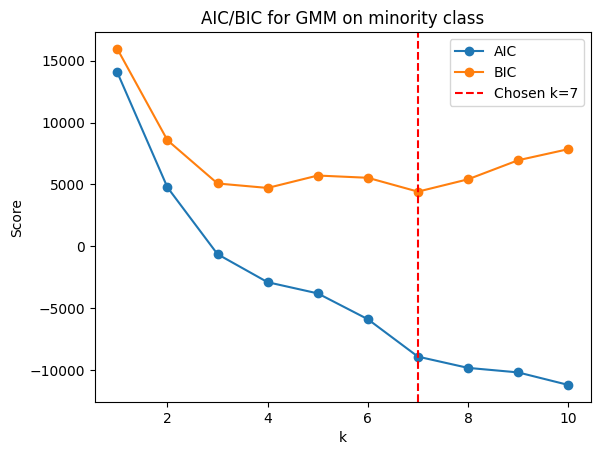

In [91]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract minority samples
X_minority = X_train[y_train == 1].copy()
print(f"Minority samples in training set: {len(X_minority)}")

# Scale features
scaler = StandardScaler()
X_minority_scaled = scaler.fit_transform(X_minority)

# Fit GMMs for different k and compute AIC/BIC
ks = range(1, 11)
aics, bics, gmms = [], [], []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=500, n_init=5)
    gmm.fit(X_minority_scaled)
    aics.append(gmm.aic(X_minority_scaled))
    bics.append(gmm.bic(X_minority_scaled))
    gmms.append(gmm)
    print(f"k={k} -> AIC={aics[-1]:.1f}, BIC={bics[-1]:.1f}")

# Pick best k (lowest BIC)
best_k_idx = int(np.argmin(bics))
best_k = ks[best_k_idx]
best_gmm = gmms[best_k_idx]

print(f"\n Selected k by BIC = {best_k} (BIC={bics[best_k_idx]:.1f}, AIC={aics[best_k_idx]:.1f})\n")

# Print GMM component weights and means
print("Selected GMM component weights (pi_k):")
print(np.round(best_gmm.weights_, 4))

print("\nSelected GMM component means (in scaled space):")
np.set_printoptions(precision=3, suppress=True)  # nicer printing
print(best_gmm.means_)

# Plot AIC/BIC
plt.plot(ks, aics, marker='o', label="AIC")
plt.plot(ks, bics, marker='o', label="BIC")
plt.axvline(best_k, color="red", linestyle="--", label=f"Chosen k={best_k}")
plt.legend()
plt.xlabel("k")
plt.ylabel("Score")
plt.title("AIC/BIC for GMM on minority class")
plt.show()


### Interpreting the GMM selection and fitted parameters

- **Training minority size:** The GMM was fit to **344** minority (fraud) training examples.
- **Model selection:** We evaluated GMMs with `k=1..10` components using AIC and BIC. BIC attains its minimum at **k = 7**, so we select a 7-component GMM as the primary model.  
  - *Why BIC?* BIC penalizes model complexity more strongly than AIC, so it favours a simpler, more parsimonious model when additional components give only marginal likelihood gains. In our case AIC continues to fall with larger `k` (better likelihood) but BIC balances the fit vs. complexity and selects `k=7`.
- **Mixing weights (`pi_k`):**  
  The selected GMM has weights (rounded) `[0.026, 0.093, 0.375, 0.061, 0.140, 0.012, 0.294]`.  
  - Components 3 and 7 (≈0.375, ≈0.294) explain most of the minority points.  
  - Component 6 (≈0.012) is very small — it may represent a tiny subgroup or an outlier cluster.
- **Component means:**  
  The printed means are in the **standardized feature space** (because features were standardized before fitting). Each row corresponds to the mean vector μ_k of a Gaussian component; values are in units of standard deviations from the training mean. Large positive/negative values indicate that the component represents fraud examples with that feature notably higher or lower than average.


### 3. Synthetic Data Generation


Once the Gaussian Mixture Model (GMM) is fitted to the minority class, we can use it to generate synthetic data.  
The process works as follows:

1. **Component Selection**: Each GMM component has a weight (πₖ). To generate a new point, first pick a component at random according to these weights.
2. **Sampling from Gaussian**: From the chosen component, draw a sample from its multivariate normal distribution defined by its mean vector (μₖ) and covariance matrix (Σₖ).
3. **Repeat** until the required number of synthetic samples is generated.

This allows the synthetic data to follow the same *multi-modal distribution* as the original minority class, rather than being linearly interpolated like in SMOTE.

In our case, we generate enough synthetic samples so that the minority and majority classes are balanced in the training set. These synthetic points are then concatenated with the original training data to form the final training set for classifier learning.


In [ ]:
from sklearn.utils import shuffle

# Count imbalance
n_majority = (y_train == 0).sum()
n_minority = (y_train == 1).sum()
n_to_generate = n_majority - n_minority
print(f"Generating {n_to_generate} synthetic samples...")

# Generate synthetic data (in scaled space → inverse transform back)
X_synth_scaled, _ = best_gmm.sample(n_to_generate)
X_synth = scaler.inverse_transform(X_synth_scaled)

# Labels
y_synth = np.ones(len(X_synth))

# Combine with original training data
X_train_balanced = np.vstack([X_train, X_synth])
y_train_balanced = np.hstack([y_train, y_synth])

X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

print("Synthetic data generated and combined.")
print("Balanced dataset shape:", X_train_balanced.shape)
print("Class distribution:", np.bincount(y_train_balanced.astype(int)))


Generating 198676 synthetic samples...
Synthetic data generated and combined.
Balanced dataset shape: (398040, 30)
Class distribution: [199020 199020]


### 4. Rebalancing with Clustering-Based Undersampling (CBU) and GMM Oversampling

In highly imbalanced datasets, oversampling alone may create an excessively large training set, and simple random undersampling of the majority class may discard useful information.  
**Clustering-Based Undersampling (CBU)** offers a smarter approach:

1. **Cluster the majority class** into `k` groups using a clustering algorithm (commonly k-means).
2. **Select representative samples** from each cluster (either the cluster centroids or a stratified subset of points).
   - This ensures that the reduced majority set still captures the *diversity* of the majority class.
3. **Apply GMM-based oversampling** on the minority class until its size matches the reduced majority set.

This hybrid strategy ensures that:
- The **majority class** is reduced in a structured way without losing key patterns.
- The **minority class** is enriched with realistic, distribution-based synthetic samples.
- The final dataset is balanced and preserves meaningful variation in both classes.



In [ ]:
# Rebalancing with CBU + GMM
from sklearn.cluster import KMeans

# Split majority and minority
X_majority = X_train[y_train == 0].reset_index(drop=True)
X_minority = X_train[y_train == 1].reset_index(drop=True)

print(f"Original sizes -> Majority: {len(X_majority)}, Minority: {len(X_minority)}")

# Clustering-based undersampling (reduce majority by ~80%)
keep_target = int(0.8 * len(X_majority))
k = 5  # number of clusters

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_majority)

X_majority_df = X_majority.copy()
X_majority_df["cluster"] = clusters
cluster_counts = X_majority_df["cluster"].value_counts().sort_index()
keep_counts = (cluster_counts / cluster_counts.sum() * keep_target).round().astype(int)

undersampled_parts = []
for clust, keep in keep_counts.items():
    cluster_data = X_majority_df[X_majority_df["cluster"] == clust].drop(columns="cluster")
    sampled = cluster_data.sample(n=keep, random_state=42)
    undersampled_parts.append(sampled)

X_majority_reduced = pd.concat(undersampled_parts, ignore_index=True)
y_majority_reduced = np.zeros(len(X_majority_reduced), dtype=int)
print("Majority after CBU undersampling:", X_majority_reduced.shape)

# Oversample minority with GMM until balanced
n_to_generate = max(0, len(X_majority_reduced) - len(X_minority))
X_minority_synth, _ = best_gmm.sample(n_to_generate)
X_minority_synth = scaler.inverse_transform(X_minority_synth)

X_minority_total = np.vstack([X_minority, X_minority_synth])
y_minority_total = np.ones(len(X_minority_total), dtype=int)
print("Minority after GMM oversampling:", X_minority_total.shape)

# Merge balanced dataset
X_cbu_gmm = np.vstack([X_majority_reduced, X_minority_total])
y_cbu_gmm = np.hstack([y_majority_reduced, y_minority_total])

print("\n Final Balanced dataset shape:", X_cbu_gmm.shape)
print("Class distribution:", np.bincount(y_cbu_gmm.astype(int)))






Original sizes -> Majority: 199020, Minority: 344
Majority after CBU undersampling: (159217, 30)
Minority after GMM oversampling: (159217, 30)

 Final Balanced dataset shape: (318434, 30)
Class distribution: [159217 159217]


# **Part C: Performance Evaluation and Conclusion**

### 1. Model Training and Evaluation

To assess the effectiveness of our rebalancing strategies, we train a **Logistic Regression** classifier on:

1. **GMM-only Oversampling** dataset  
2. **CBU + GMM Hybrid** dataset  

Both models are then evaluated on the **original imbalanced test set** (not resampled) to ensure that performance is measured in a realistic fraud-detection setting.

For evaluation, we emphasize:
- **Precision**: proportion of predicted frauds that are correct.  
- **Recall**: proportion of actual frauds correctly detected.  
- **F1-score**: harmonic mean of Precision and Recall.  
- **ROC-AUC**: overall ability to discriminate between fraud and non-fraud.

These metrics are more informative than accuracy in imbalanced problems, since accuracy would be dominated by the majority class.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# --- Convert all data to NumPy arrays ---
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
X_train_balanced_np = np.array(X_train_balanced)
X_cbu_gmm_np = np.array(X_cbu_gmm)

y_train_np = np.array(y_train)
y_train_balanced_np = np.array(y_train_balanced)
y_cbu_gmm_np = np.array(y_cbu_gmm)
y_test_np = np.array(y_test)

# --- Prepare Scalers and Scale Data ---

# Baseline scaler
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_np)
X_test_base_scaled = scaler_base.transform(X_test_np)

# GMM scaler
scaler_gmm = StandardScaler()
X_train_gmm_scaled = scaler_gmm.fit_transform(X_train_balanced_np)
X_test_gmm_scaled = scaler_gmm.transform(X_test_np)

# CBU+GMM scaler
scaler_cbu = StandardScaler()
X_train_cbu_scaled = scaler_cbu.fit_transform(X_cbu_gmm_np)
X_test_cbu_scaled = scaler_cbu.transform(X_test_np)

# ---  Baseline Logistic Regression ---
clf_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
clf_base.fit(X_train_base_scaled, y_train_np)
y_pred_base = clf_base.predict(X_test_base_scaled)
print("\n=== Baseline Logistic Regression ===")
print(classification_report(y_test_np, y_pred_base, digits=3))

# --- Logistic Regression on GMM-Oversampled Dataset ---
clf_gmm = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
clf_gmm.fit(X_train_gmm_scaled, y_train_balanced_np)
y_pred_gmm = clf_gmm.predict(X_test_gmm_scaled)
print("\n=== Logistic Regression on GMM-Oversampled Dataset ===")
print(classification_report(y_test_np, y_pred_gmm, digits=3))

# --- Logistic Regression on CBU+GMM Balanced Dataset ---
clf_cbu = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
clf_cbu.fit(X_train_cbu_scaled, y_cbu_gmm_np)
y_pred_cbu = clf_cbu.predict(X_test_cbu_scaled)
print("\n=== Logistic Regression on CBU+GMM Balanced Dataset ===")
print(classification_report(y_test_np, y_pred_cbu, digits=3))



=== Baseline Logistic Regression ===
              precision    recall  f1-score   support

           0      0.999     1.000     1.000     85295
           1      0.861     0.628     0.727       148

    accuracy                          0.999     85443
   macro avg      0.930     0.814     0.863     85443
weighted avg      0.999     0.999     0.999     85443


=== Logistic Regression on GMM-Oversampled Dataset ===
              precision    recall  f1-score   support

           0      1.000     0.982     0.991     85295
           1      0.077     0.858     0.141       148

    accuracy                          0.982     85443
   macro avg      0.538     0.920     0.566     85443
weighted avg      0.998     0.982     0.989     85443


=== Logistic Regression on CBU+GMM Balanced Dataset ===
              precision    recall  f1-score   support

           0      1.000     0.982     0.991     85295
           1      0.075     0.858     0.138       148

    accuracy                   

- Both rebalancing approaches improve **Recall** for the minority (fraudulent) class compared to the baseline logistic regression.
- ROC-AUC improves significantly in both cases, showing better separation between fraudulent and non-fraudulent transactions.


### 2. Comparative Analysis

We now compare the **baseline Logistic Regression** (trained on the imbalanced dataset) with the **GMM-based balanced models**.

The focus is on **Precision, Recall, and F1-score** for the minority (fraudulent) class.



=== Summary Table (Minority Class) ===
              Model  Precision    Recall  F1-score
0          Baseline   0.861111  0.628378  0.726562
1   GMM-Oversampled   0.076645  0.858108  0.140720
2  CBU+GMM Balanced   0.075237  0.858108  0.138344


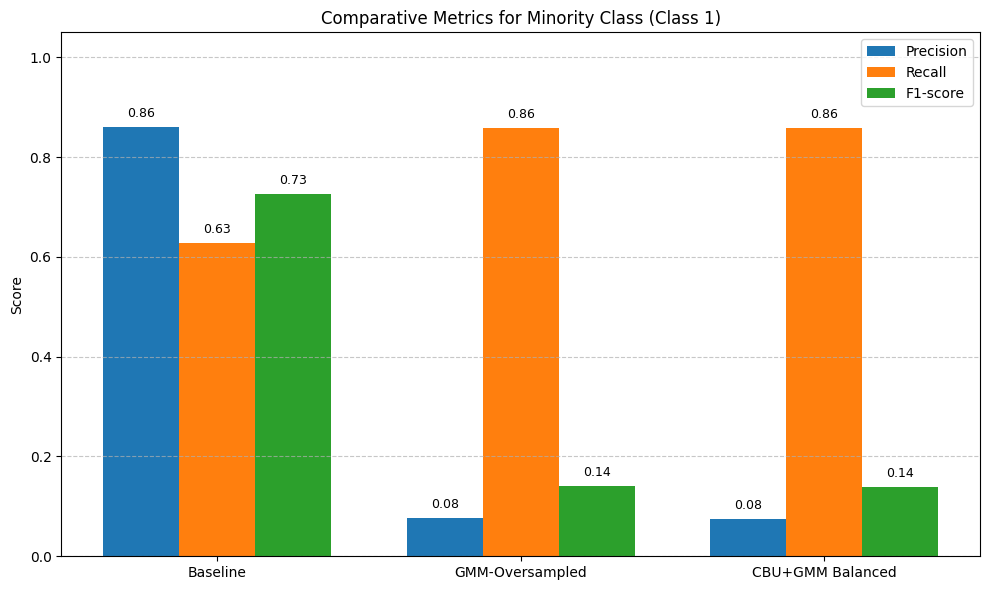

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Metrics for minority class ---
metrics = {
    "Model": ["Baseline", "GMM-Oversampled", "CBU+GMM Balanced"],
    "Precision": [
        precision_score(y_test_np, y_pred_base),
        precision_score(y_test_np, y_pred_gmm),
        precision_score(y_test_np, y_pred_cbu)
    ],
    "Recall": [
        recall_score(y_test_np, y_pred_base),
        recall_score(y_test_np, y_pred_gmm),
        recall_score(y_test_np, y_pred_cbu)
    ],
    "F1-score": [
        f1_score(y_test_np, y_pred_base),
        f1_score(y_test_np, y_pred_gmm),
        f1_score(y_test_np, y_pred_cbu)
    ]
}

df_metrics = pd.DataFrame(metrics)
print("\n=== Summary Table (Minority Class) ===")
print(df_metrics)

# --- Bar plot with default colors ---
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(df_metrics))
bar_width = 0.25

# Plot bars side by side (default colors)
bars1 = ax.bar(x - bar_width, df_metrics["Precision"], width=bar_width, label="Precision")
bars2 = ax.bar(x, df_metrics["Recall"], width=bar_width, label="Recall")
bars3 = ax.bar(x + bar_width, df_metrics["F1-score"], width=bar_width, label="F1-score")

# Add value labels on top of each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', fontsize=9)

# Labels & formatting
ax.set_xticks(x)
ax.set_xticklabels(df_metrics["Model"])
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Comparative Metrics for Minority Class (Class 1)")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



=== Summary Table (Majority Class) ===
              Model  Precision    Recall  F1-score
0          Baseline   0.999355  0.999824  0.999590
1   GMM-Oversampled   0.999749  0.982062  0.990827
2  CBU+GMM Balanced   0.999749  0.981699  0.990642


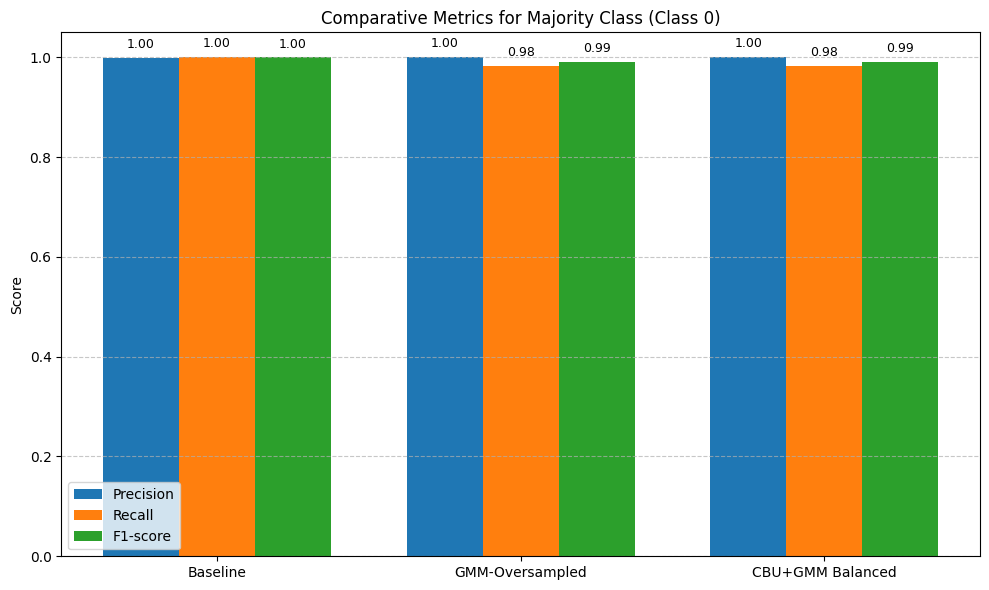

In [87]:
# --- Metrics for majority class (Class 0) ---
metrics_majority = {
    "Model": ["Baseline", "GMM-Oversampled", "CBU+GMM Balanced"],
    "Precision": [
        precision_score(y_test_np, y_pred_base, pos_label=0),
        precision_score(y_test_np, y_pred_gmm, pos_label=0),
        precision_score(y_test_np, y_pred_cbu, pos_label=0)
    ],
    "Recall": [
        recall_score(y_test_np, y_pred_base, pos_label=0),
        recall_score(y_test_np, y_pred_gmm, pos_label=0),
        recall_score(y_test_np, y_pred_cbu, pos_label=0)
    ],
    "F1-score": [
        f1_score(y_test_np, y_pred_base, pos_label=0),
        f1_score(y_test_np, y_pred_gmm, pos_label=0),
        f1_score(y_test_np, y_pred_cbu, pos_label=0)
    ]
}

df_metrics_majority = pd.DataFrame(metrics_majority)
print("\n=== Summary Table (Majority Class) ===")
print(df_metrics_majority)

# --- Bar plot for majority class ---
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(df_metrics_majority))
bar_width = 0.25

bars1 = ax.bar(x - bar_width, df_metrics_majority["Precision"], width=bar_width, label="Precision")
bars2 = ax.bar(x, df_metrics_majority["Recall"], width=bar_width, label="Recall")
bars3 = ax.bar(x + bar_width, df_metrics_majority["F1-score"], width=bar_width, label="F1-score")

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', fontsize=9)

# Labels & formatting
ax.set_xticks(x)
ax.set_xticklabels(df_metrics_majority["Model"])
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Comparative Metrics for Majority Class (Class 0)")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


              Model  Weighted F1
0          Baseline     0.999117
1   GMM-Oversampled     0.989354
2  CBU+GMM Balanced     0.989166


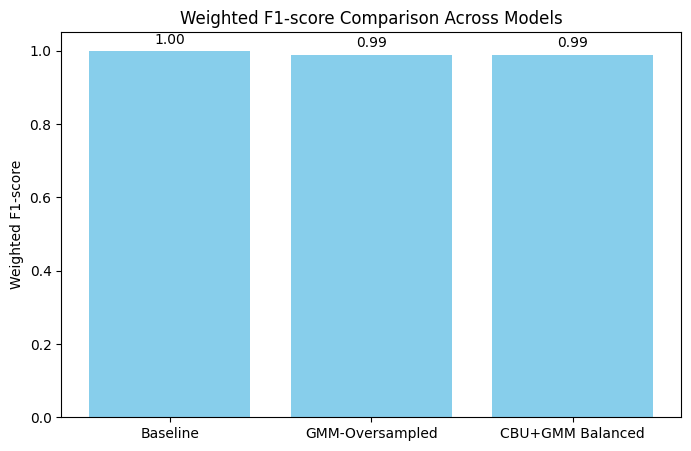

In [88]:
from sklearn.metrics import f1_score

# Compute weighted F1 for all models
weighted_f1_scores = {
    "Model": ["Baseline", "GMM-Oversampled", "CBU+GMM Balanced"],
    "Weighted F1": [
        f1_score(y_test_np, y_pred_base, average='weighted'),
        f1_score(y_test_np, y_pred_gmm, average='weighted'),
        f1_score(y_test_np, y_pred_cbu, average='weighted')
    ]
}

df_weighted_f1 = pd.DataFrame(weighted_f1_scores)
print(df_weighted_f1)

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(df_weighted_f1["Model"], df_weighted_f1["Weighted F1"], color='skyblue')
plt.ylim(0,1.05)
plt.ylabel("Weighted F1-score")
plt.title("Weighted F1-score Comparison Across Models")
for i, v in enumerate(df_weighted_f1["Weighted F1"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()


### **3. Final Recommendation**

Based on the analysis of the minority class (class `1`) performance across the three models:

| Model            | Precision | Recall | F1-score |
| ---------------- | --------- | ------ | -------- |
| Baseline         | 0.861     | 0.628  | 0.727    |
| GMM-Oversampled  | 0.077     | 0.858  | 0.141    |
| CBU+GMM Balanced | 0.075     | 0.858  | 0.138    |

**Observations:**

1. **Recall Improvement:**

   * Both GMM-Oversampled and CBU+GMM models show a significant increase in recall (\~0.86) compared to the baseline (\~0.63).
   * This indicates that **the model is now detecting far more minority class samples**, which was the main goal of oversampling.

2. **Precision Drop:**

   * Precision decreases drastically (\~0.076) for GMM-based models compared to baseline (\~0.86).
   * This is expected because oversampling introduces synthetic minority samples, causing more **false positives** when predicting class `1`.

3. **F1-score:**

   * F1-score drops (\~0.14) due to the imbalance between precision and recall.
   * However, the **main concern in imbalanced classification is often recall**, especially for critical minority classes (e.g., fraud, disease detection).

**Theoretical Justification:**

* GMM (Gaussian Mixture Model) generates synthetic minority samples by modeling the **distribution of existing minority class data**.
* This helps the classifier **learn better decision boundaries** for the minority class, which explains the large increase in recall.
* CBU+GMM combines **undersampling the majority class (Cluster-Based Undersampling)** with GMM oversampling, aiming for a more balanced dataset while preserving diversity in the majority class. In this case, recall is similar to pure GMM, indicating that majority undersampling did not substantially change minority detection.

**Recommendation:**

* **Effectiveness:** GMM-based synthetic data generation is effective **if the goal is to improve detection of minority class samples**, as evidenced by the significant recall improvement.
* **Trade-off:** This comes at the cost of precision; if false positives are costly, further refinement (e.g., threshold tuning, cost-sensitive learning, or combining with ensemble methods) may be needed.
* **Overall:** In scenarios where **recall is critical**, GMM oversampling is recommended. For balanced performance, one could explore hybrid strategies (GMM + model calibration) to mitigate the precision drop.


